In [ ]:
# This information helps with debugging and getting support :)
import sys, platform
import pandas as pd
import bifacial_radiance as br
print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("bifacial_radiance version ", br.__version__)

# 11 - AgriPV Systems

This journal shows how to model an AgriPV site, calculating the irradiance not only on the modules but also the irradiance received by the ground to evaluate available solar ersource for plants. 

We assume that bifacia_radiacne is already installed in your computer. This works for bifacial_radiance v.3 release.

These journal outlines 4 useful uses of bifacial_radiance and some tricks: 

* Creating the modules in the AgriPV site
* Adding extra geometry for the pillars/posts supporting the AgriPV site
* Hacking the sensors to sample the ground irradiance and create irradiance map
* Adding object to simulate variations in ground albedo from different crops between rows.


#### Steps:

1. <a href='#step1'> Generate the geometry </a>
2. <a href='#step2'> Analyse the Ground Irradiance </a>
3. <a href='#step3'> Analyse and MAP the Ground Irradiance </a>
4. <a href='#step4'> Adding different Albedo Section </a>
    
#### Preview of what we will create: 
    
![Another view](../images_wiki/AdvancedJournals/AgriPV_2.PNG)
![AgriPV Image We will create](../images_wiki/AdvancedJournals/AgriPV_1.PNG)
And this is how it will look like:

![AgriPV modeled step 4](../images_wiki/AdvancedJournals/AgriPV_step4.PNG)




<a id='step1'></a>

## 1. Generate the geometry 

This section goes from setting up variables to making the OCT axis. We are also adding some custom elements for the torquetubes and posts.

We've done this before a couple times, no new stuff here. 

The magic is that, for doing the carport we see in the figure, we are going to do a 4-up configuration of modules (**numpanels**), and we are going to repeat that 3-UP 6 times (**nMods**)

In [1]:
import os
from pathlib import Path

testfolder = str(Path().resolve().parent.parent / 'bifacial_radiance' / 'TEMP' /  'Tutorial_11')

if not os.path.exists(testfolder):
    os.makedirs(testfolder)
    
print ("Your simulation will be stored in %s" % testfolder)

Your simulation will be stored in C:\Users\mprillim\sam_dev\bifacial_radiance\bifacial_radiance\TEMP\Tutorial_11


In [2]:
from bifacial_radiance import *   
import numpy as np
import pandas as pd

In [3]:
simulationname = 'tutorial_11'

#Location:
lat = 40.0583  # NJ
lon = -74.4057  # NJ

# MakeModule Parameters
moduletype='test-module'
numpanels = 3  # AgriPV site has 3 modules along the y direction (N-S since we are facing it to the south) .
x = 0.95  
y = 1.95
xgap = 2.0# Leaving 15 centimeters between modules on x direction
ygap = 0.10 # Leaving 10 centimeters between modules on y direction
zgap = 0 # no gap to torquetube.
sensorsy = 6*numpanels  # this will give 6 sensors per module, 1 per cell

# Other default values:

# TorqueTube Parameters
axisofrotationTorqueTube=False  # this is False by default if there is no torquetbue parameters
torqueTube = False
cellLevelModule = True

numcellsx = 12
numcellsy = 6
xcell = 0.156
ycell = 0.156
xcellgap = 0.02
ycellgap = 0.02

cellLevelModuleParams = {'numcellsx': numcellsx, 'numcellsy':numcellsy, 
                         'xcell': xcell, 'ycell': ycell, 'xcellgap': xcellgap, 'ycellgap': ycellgap}

# SceneDict Parameters
pitch = 15 # m
albedo = 0.2  #'grass'     # ground albedo
hub_height = 4.3 # m  
nMods = 6 # six modules per row.
nRows = 3  # 3 row

azimuth_ang=180 # Facing south
tilt =35 # tilt. 

# Now let's run the example

demo = RadianceObj(simulationname,path = testfolder)  
demo.setGround(albedo) 
epwfile = demo.getEPW(lat, lon) # NJ lat/lon 40.0583° N, 74.4057
metdata = demo.readWeatherFile(epwfile, coerce_year=2001) 
timestamp = metdata.datetime.index(pd.to_datetime('2001-06-17 13:0:0 -5'))  # Make this timezone aware, use -5 for EST.
demo.gendaylit(timestamp)  


# Making module with all the variables
module=demo.makeModule(name=moduletype,x=x,y=y,numpanels=numpanels, 
                           xgap=xgap, ygap=ygap, cellModule=cellLevelModuleParams)
# create a scene with all the variables
sceneDict = {'tilt':tilt,'pitch': 15,'hub_height':hub_height,'azimuth':azimuth_ang, 'nMods': nMods, 'nRows': nRows}  
scene = demo.makeScene(module=moduletype, sceneDict=sceneDict) 
octfile = demo.makeOct(demo.getfilelist())


path = C:\Users\mprillim\sam_dev\bifacial_radiance\bifacial_radiance\TEMP\Tutorial_11
Loading albedo, 1 value(s), 0.200 avg
1 nonzero albedo values.
Getting weather file: USA_NJ_McGuire.AFB.724096_TMY3.epw
 ... OK!
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2001
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos

Module Name: test-module
Module was shifted by 0.078 in X to avoid sensors on air
This is a Cell-Level detailed module with Packaging Factor of 0.81 %
Module test-module updated in module.json
Pre-existing .rad file objects\test-module.rad will be overwritten

Created tutorial_11.oct


If desired, you can view the Oct file at this point:

***rvu -vf views\front.vp -e .01 tutorial_11.oct***

In [4]:

## Comment the ! line below to run rvu from the Jupyter notebook instead of your terminal.
## Simulation will stop until you close the rvu window

#!rvu -vf views\front.vp -e .01 tutorial_11.oct



And adjust the view parameters, you should see this image.

![AgriPV modeled step 1](../images_wiki/AdvancedJournals/AgriPV_step1.PNG)


### Adding the structure

We will add on the torquetube and pillars.

Positions of the piles could be done more programatically, but they are kinda estimated at the moment. 

In [5]:
torquetubelength = module.scenex*(nMods) 

name='Post1'
text='! genbox Metal_Aluminum_Anodized torquetube_row1 {} 0.2 0.3 | xform -t {} -0.1 -0.3 | xform -t 0 0 4.2'.format(
                                                    torquetubelength, (-torquetubelength+module.sceney)/2.0)
customObject = demo.makeCustomObject(name,text)
demo.appendtoScene(radfile=scene.radfiles, customObject=customObject, text="!xform -rz 0")

name='Post2'
text='! genbox Metal_Aluminum_Anodized torquetube_row2 {} 0.2 0.3 | xform -t {} -0.1 -0.3 | xform -t 0 15 4.2'.format(
                                            torquetubelength, (-torquetubelength+module.sceney)/2.0)
customObject = demo.makeCustomObject(name,text)
demo.appendtoScene(radfile=scene.radfiles, customObject=customObject, text="!xform -rz 0")

name='Post3'
text='! genbox Metal_Aluminum_Anodized torquetube_row2 {} 0.2 0.3 | xform -t {} -0.1 -0.3 | xform -t 0 -15 4.2'.format(
                                              torquetubelength, (-torquetubelength+module.sceney)/2.0)
customObject = demo.makeCustomObject(name,text)
demo.appendtoScene(radfile=scene.radfiles, customObject=customObject, text="!xform -rz 0")



Custom Object Name objects\Post1.rad

Custom Object Name objects\Post2.rad

Custom Object Name objects\Post3.rad


In [6]:
name='Pile'
pile1x = (torquetubelength+module.sceney)/2.0
pilesep = pile1x*2.0/7.0

text= '! genrev Metal_Grey tube1row1 t*4.2 0.15 32 | xform -t {} 0 0'.format(pile1x)
text += '\r\n! genrev Metal_Grey tube1row2 t*4.2 0.15 32 | xform -t {} 15 0'.format(pile1x)
text += '\r\n! genrev Metal_Grey tube1row3 t*4.2 0.15 32 | xform -t {} -15 0'.format(pile1x)

for i in range (1, 7):
    text += '\r\n! genrev Metal_Grey tube{}row1 t*4.2 0.15 32 | xform -t {} 0 0'.format(i+1, pile1x-pilesep*i)
    text += '\r\n! genrev Metal_Grey tube{}row2 t*4.2 0.15 32 | xform -t {} 15 0'.format(i+1, pile1x-pilesep*i)
    text += '\r\n! genrev Metal_Grey tube{}row3 t*4.2 0.15 32 | xform -t {} -15 0'.format(i+1, pile1x-pilesep*i)

customObject = demo.makeCustomObject(name,text)
demo.appendtoScene(radfile=scene.radfiles, customObject=customObject, text="!xform -rz 0")

octfile = demo.makeOct()  # makeOct combines all of the ground, sky and object files we just added into a .oct file.


Custom Object Name objects\Pile.rad
Created tutorial_11.oct


### View the geometry with the posts on :

***rvu -vf views\front.vp -e .01 -pe 0.4 -vp 12 -10 3.5 -vd -0.0995 0.9950 0.0 tutorial_11.oct***



In [7]:

## Comment the ! line below to run rvu from the Jupyter notebook instead of your terminal.
## Simulation will stop until you close the rvu window

#!rvu -vf views\front.vp -e .01 tutorial_11.oct



![AgriPV modeled step 2](../images_wiki/AdvancedJournals/AgriPV_step2.PNG)

<a id='step2'></a>

## 2. Analyse  the Ground Irradiance

Now let's do some analysis along the ground, starting from the edge of the modules. We wil select to start in the center of the array.

We are also increasign the number of points sampled accross the collector width, with the  variable **sensorsy** passed to **moduleanalysis**. We are also increasing the step between sampling points, to be able to sample in between the rows.

In [8]:
analysis = AnalysisObj(octfile, demo.name)  
sensorsy = 20
frontscan, backscan = analysis.moduleAnalysis(scene, sensorsy=sensorsy)


In [9]:
groundscan = frontscan

In [10]:
groundscan['zstart'] = 0.05  # setting it 5 cm from the ground.
groundscan['zinc'] = 0   # no tilt necessary. 
groundscan['yinc'] = pitch/(sensorsy-1)   # increasing spacing so it covers all distance between rows
groundscan

{'xstart': 1.5159739062663865e-16,
 'ystart': -1.237886635821746,
 'zstart': 0.05,
 'xinc': -1.5802346387185998e-17,
 'yinc': 0.7894736842105263,
 'zinc': 0,
 'sx_xinc': 0.0,
 'sx_yinc': 0.0,
 'sx_zinc': 0.0,
 'Nx': 1,
 'Ny': 20,
 'Nz': 1,
 'orient': '-0.000 0.574 -0.819'}

In [11]:
analysis.analysis(octfile, simulationname+"_groundscan", groundscan, backscan)  # compare the back vs front irradiance  


Linescan in process: tutorial_11_groundscan_Front
Linescan in process: tutorial_11_groundscan_Back
Saved: results\irr_tutorial_11_groundscan.csv


({'Wm2': [707.7193666666666,
   679.3139666666666,
   320.71520000000004,
   321.5017,
   326.947,
   355.2678,
   703.1252000000001,
   717.6289666666667,
   730.9323333333333,
   738.5453666666667,
   744.1402333333334,
   748.625,
   750.1326666666668,
   753.2622333333334,
   754.2802333333333,
   753.4847333333332,
   749.6281333333333,
   744.2707333333334,
   730.8705333333334,
   709.3668333333334],
  'x': [1.515974e-16,
   1.35795e-16,
   1.199927e-16,
   1.041904e-16,
   8.838801e-17,
   7.258566e-17,
   5.678331e-17,
   4.098097e-17,
   2.517862e-17,
   9.376273e-18,
   -6.426073e-18,
   -2.222842e-17,
   -3.803077e-17,
   -5.383311e-17,
   -6.963546e-17,
   -8.543781e-17,
   -1.012402e-16,
   -1.170425e-16,
   -1.328448e-16,
   -1.486472e-16],
  'y': [-1.237887,
   -0.448413,
   0.3410607,
   1.130534,
   1.920008,
   2.709482,
   3.498955,
   4.288429,
   5.077903,
   5.867377,
   6.65685,
   7.446324,
   8.235798,
   9.025271,
   9.814745,
   10.60422,
   11.39369,
   12.

This is the result for only one 'chord' accross the ground. Let's now do a X-Y scan of the ground.

<a id='step3'></a>

## 3. Analyse and MAP the Ground Irradiance

 We will use the same technique to find the irradiance on the ground used above, but will move it along the X-axis to map from the start of one module to the next.
 
 We will sample around the module that is placed at the center of the field.

![AgriPV modeled step 4](../images_wiki/AdvancedJournals/spacing_between_modules.PNG)

In [12]:
import seaborn as sns

In [13]:
sensorsx = 20
startgroundsample=-module.scenex
spacingbetweensamples = module.scenex/(sensorsx-1)

for i in range (0, sensorsx): # Will map 20 points    
    frontscan, backscan = analysis.moduleAnalysis(scene, sensorsy=sensorsy)
    groundscan = frontscan
    groundscan['zstart'] = 0.05  # setting it 5 cm from the ground.
    groundscan['zinc'] = 0   # no tilt necessary. 
    groundscan['yinc'] = pitch/(sensorsy-1)   # increasing spacing so it covers all distance between rows
    groundscan['xstart'] = startgroundsample + i*spacingbetweensamples   # increasing spacing so it covers all distance between rows
    analysis.analysis(octfile, simulationname+"_groundscan_"+str(i), groundscan, backscan)  # compare the back vs front irradiance  


Linescan in process: tutorial_11_groundscan_0_Front
Linescan in process: tutorial_11_groundscan_0_Back
Saved: results\irr_tutorial_11_groundscan_0.csv
Linescan in process: tutorial_11_groundscan_1_Front
Linescan in process: tutorial_11_groundscan_1_Back
Saved: results\irr_tutorial_11_groundscan_1.csv
Linescan in process: tutorial_11_groundscan_2_Front
Linescan in process: tutorial_11_groundscan_2_Back
Saved: results\irr_tutorial_11_groundscan_2.csv
Linescan in process: tutorial_11_groundscan_3_Front
Linescan in process: tutorial_11_groundscan_3_Back
Saved: results\irr_tutorial_11_groundscan_3.csv
Linescan in process: tutorial_11_groundscan_4_Front
Linescan in process: tutorial_11_groundscan_4_Back
Saved: results\irr_tutorial_11_groundscan_4.csv
Linescan in process: tutorial_11_groundscan_5_Front
Linescan in process: tutorial_11_groundscan_5_Back
Saved: results\irr_tutorial_11_groundscan_5.csv
Linescan in process: tutorial_11_groundscan_6_Front
Linescan in process: tutorial_11_groundsca

Read all the files generated into one dataframe

In [14]:
filestarter = "irr_tutorial_11_groundscan_"

filelist = sorted(os.listdir(os.path.join(testfolder, 'results')))
prefixed = [filename for filename in filelist if filename.startswith(filestarter)]
arrayWm2Front = []
arrayWm2Back = []
arrayMatFront = []
arrayMatBack = []
filenamed = []
faillist = []

print('{} files in the directory'.format(filelist.__len__()))
print('{} groundscan files in the directory'.format(prefixed.__len__()))
i = 0  # counter to track # files loaded.

for i in range (0, len(prefixed)):
    ind = prefixed[i].split('_')

    try:
        resultsDF = load.read1Result(os.path.join(testfolder, 'results', prefixed[i]))
        arrayWm2Front.append(list(resultsDF['Wm2Front']))
        arrayWm2Back.append(list(resultsDF['Wm2Back']))
        arrayMatFront.append(list(resultsDF['mattype']))
        arrayMatBack.append(list(resultsDF['rearMat']))
        filenamed.append(prefixed[i])
    except:
        print(" FAILED ", i, prefixed[i])
        faillist.append(prefixed[i])

resultsdf = pd.DataFrame(list(zip(arrayWm2Front, arrayWm2Back, 
                                  arrayMatFront, arrayMatBack)),
                         columns = ['br_Wm2Front', 'br_Wm2Back', 
                                    'br_MatFront', 'br_MatBack'])
resultsdf['filename'] = filenamed

21 files in the directory
20 groundscan files in the directory


Creating a new dataframe where  each element in the front irradiance list is a column. Also transpose and reverse so it looks like a top-down view of the ground.

In [15]:
df3 = pd.DataFrame(resultsdf['br_Wm2Front'].to_list())
reversed_df = df3.T.iloc[::-1]

In [16]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
print(sns)

<module 'seaborn' from 'C:\\Users\\mprillim\\AppData\\Local\\anaconda3\\Lib\\site-packages\\seaborn\\__init__.py'>


            0           1           2           3           4           5   \
19  706.103133  708.401400  721.409200  717.619833  715.598133  714.769967   
18  729.545700  730.459500  736.484300  733.422067  733.810267  732.349067   
17  744.611167  744.542333  744.579000  744.724633  750.426100  744.390300   
16  750.814333  751.606700  749.812433  750.632400  751.096500  750.848633   
15  753.168167  753.276833  753.276567  755.596267  752.409900  752.694000   
14  755.519533  752.961300  752.966167  755.388967  753.513033  752.432300   
13  754.755633  752.870133  752.360067  752.922700  752.463167  753.046767   
12  750.480900  752.070000  750.826967  751.828333  751.950300  752.030000   
11  748.509767  747.130000  749.399867  746.466000  748.227600  746.539433   
10  745.415200  744.417000  743.864667  744.758867  744.103900  742.821967   
9   738.088100  739.890267  741.674200  738.149167  737.464833  736.426367   
8   731.910667  730.627967  729.591467  731.874200  731.301133  

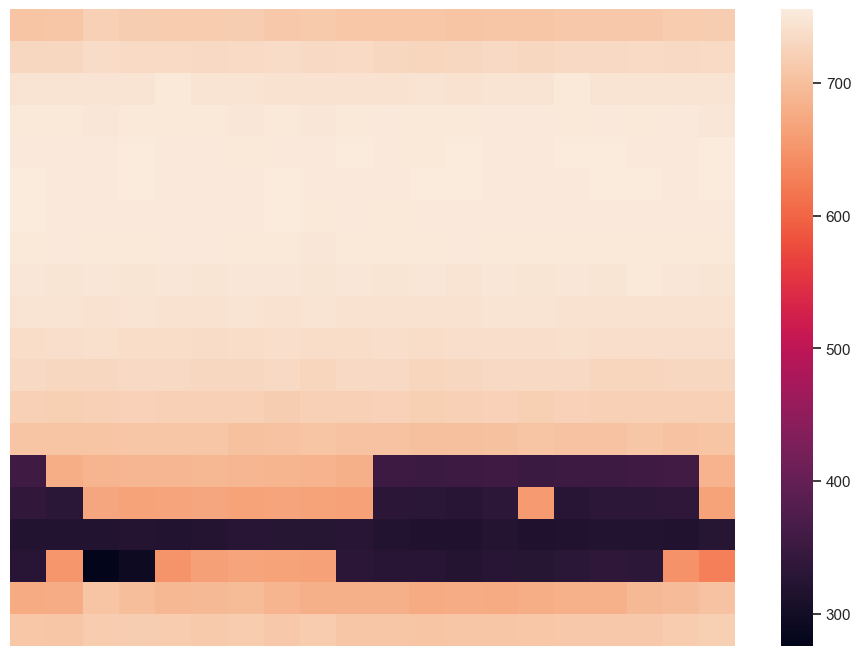

In [17]:
# Plot
print(reversed_df)
ax = sns.heatmap(reversed_df)
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylabel('')  
ax.set_xlabel('')  
print('')

<a id='step4'></a>

## 4. Adding different Albedo Sections
Add a surface (just like we added the pillars) with a specific reflectivity to represent different albedo sections. In the image, we can see that the albedo between the crops is different than the crop albedo. Let's assume that the abledo between the crops is higher than the crop's albedo which wa previuosly set a 0.2.



In [18]:
name='Center_Grass'
carpositionx=-2
carpositiony=-1
text='! genbox white_EPDM CenterPatch 28 12 0.1 | xform -t -14 2 0'.format(carpositionx, carpositiony)
customObject = demo.makeCustomObject(name,text)
demo.appendtoScene(scene.radfiles, customObject, '!xform -rz 0')

octfile = demo.makeOct(demo.getfilelist()) 



Custom Object Name objects\Center_Grass.rad
Created tutorial_11.oct


Viewing with rvu:

![AgriPV modeled step 4](../images_wiki/AdvancedJournals/AgriPV_step4.PNG)

